### Analysis

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Embedding, LSTM, Dropout, SimpleRNN, Flatten, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Model
import tensorflow as tf
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.callbacks import EarlyStopping
import time

#### Load Data

In [ ]:
# Load the dataset
df = pd.read_csv(r'spam_Emails_data.csv')
print(df.head())

  label                                               text
0  Spam  viiiiiiagraaaa\nonly for the ones that want to...
1   Ham  got ice thought look az original message ice o...
2  Spam  yo ur wom an ne eds an escapenumber in ch ma n...
3  Spam  start increasing your odds of success & live s...
4   Ham  author jra date escapenumber escapenumber esca...


In [ ]:
print(df.columns)

Index(['label', 'text'], dtype='object')


#### Dataset Samples

In [ ]:
# Check if the data loaded correctly
print("Dataset loaded successfully.")
print(f"Number of samples: {len(df)}")
print(df.tail())

Dataset loaded successfully.
Number of samples: 118632
       label                                               text
118627  Spam  hi lowest mortgage fees obligations commitment...
118628  Spam  b vescapenumber e pjs j oev bp j pjs n e j f b...
118629   Ham  on thu escapenumber apr escapenumber nathanael...
118630   Ham  kim heard about your cat very sorry about it i...
118631   Ham  start date escapenumber escapenumber escapenum...


#### Shape of the Dataset

In [ ]:
X = df.drop('label', axis = 1).values
y = df['label'].values

print(X.shape, y.shape)

(118632, 1) (118632,)


In [ ]:
print(f"This data contains {df.shape[0]} rows and {df.shape[1]} columns. ")

This data contains 118632 rows and 2 columns. 


In [ ]:
df.duplicated().sum()

0

#### Pie Chart Distribution of the Dataset

In [ ]:

emails = df['label'].value_counts()

# Create a DataFrame for Plotly
emails_df = pd.DataFrame({
    'Label': emails.index,
    'Count': emails.values
})

# Create a Plotly pie chart
fig = px.pie(emails_df,
             names='Label',
             values='Count',
             color_discrete_sequence=['blue', 'pink'],  # Set custom colors
             title='Pie Graph: Spam or Not')

# Customize the appearance
fig.update_traces(
    hoverinfo='label+percent',
    textinfo='label+value+percent',
    textfont_size=15,
    textposition='outside',  # Position text outside the pie
    marker=dict(line=dict(color='rgba(0,0,0,0)', width=0)),  # Remove the outline
    pull=[0.1, 0.1]  # Slightly pull out each segment for better visibility
)

# Customize legend
fig.update_layout(
    legend=dict(
        orientation="h",  # Horizontal orientation of legend
        yanchor="bottom",
        y=-0.2,  # Adjust the vertical position of the legend
        xanchor="center",
        x=0.5  # Center the legend horizontally
    ),
    autosize=False,
    width=400,  # Set width in pixels
    height=400  # Set height in pixels
)

# Show the pie chart
fig.show()


#### Length of Distribution

In [ ]:

# Display basic info about the DataFrame
print("DataFrame info:")
print(df.info())

# Check for missing values and types in 'text' column
print("Checking for missing or non-string values in 'text':")
print(df['text'].apply(type).value_counts())  # Counts of different data types in 'text'

# Replace non-string values with empty string or NaN
df['text'] = df['text'].astype(str)

# Compute the length of each message
df['length'] = df['text'].apply(len)

# Separate ham and spam messages
ham = df[df['label'].str.strip().str.lower() == 'ham']
spam = df[df['label'].str.strip().str.lower() == 'spam']

# Print data to confirm
print("Ham DataFrame:")
print(ham.head())
print("Spam DataFrame:")
print(spam.head())

# Check lengths of the messages
print("Ham Lengths:")
print(ham['length'].describe())
print("Spam Lengths:")
print(spam['length'].describe())

# Data for distribution plot
if not ham.empty and not spam.empty:
    hist_data = [ham['length'].tolist(), spam['length'].tolist()]
    group_labels = ['ham', 'spam']
    colors = ['black', 'red']

    # Create distribution plot
    fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)

    # Add title
    fig.update_layout(title_text='Length Distribution of Ham and Spam Messages',
                      template='simple_white')

    # Show plot
    fig.show()
else:
    print("No data available for plotting.")


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118632 entries, 0 to 118631
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   118632 non-null  object
 1   text    118631 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB
None
Checking for missing or non-string values in 'text':
text
<class 'str'>      118631
<class 'float'>         1
Name: count, dtype: int64
Ham DataFrame:
  label                                               text  length
1   Ham  got ice thought look az original message ice o...     530
4   Ham  author jra date escapenumber escapenumber esca...    3097
6   Ham  attached is the weekly deal report from 10 / 1...     153
7   Ham  this is the version that we created earlier th...     319
8   Ham  pulp writing printing paper escapenumber escap...    7896
Spam DataFrame:
   label                                               text  length
0   Spam  viiiiiiagraaaa\nonly for the ones 

#### Rank of Ham Terms

In [ ]:

# Separate ham messages
ham = df[df['label'].str.strip().str.lower() == 'ham']

# Tokenize and count terms
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(ham['text'])
term_freq = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

# Create a DataFrame with term frequencies
freq_df = pd.DataFrame({'Term': terms, 'Frequency': term_freq})
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Select the top 10 terms
top_10 = freq_df.head(10)

# Plot using Plotly Express
fig = px.bar(top_10, x='Term', y='Frequency', text='Frequency', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn,
             title='Rank of Ham Terms',
             template="simple_white")

# Customize plot
for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"

fig.update_traces(textposition='inside',
                  textfont_size=11)

# Show plot
fig.show()


#### World Cloud of Ham Messages

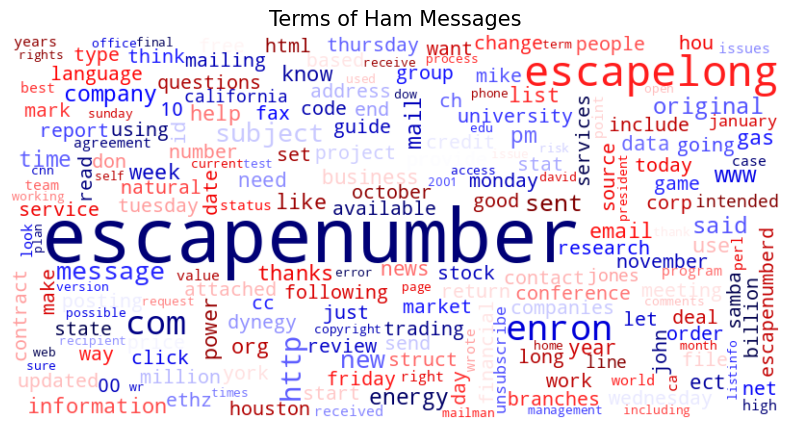

In [ ]:

# Separate ham messages
ham = df[df['label'].str.strip().str.lower() == 'ham']

# Tokenize and count terms
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(ham['text'])
term_freq = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

# Create a DataFrame with term frequencies
freq_df = pd.DataFrame({'Term': terms, 'Frequency': term_freq})
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Prepare data for WordCloud
data = dict(zip(freq_df['Term'], freq_df['Frequency']))

# Create and display the Word Cloud
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='seismic',
                      contour_color='black',
                      contour_width=1).generate_from_frequencies(data)

# Plot the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Terms of Ham Messages', fontsize=15)
plt.show()


#### Bar chart of Spam Messages

In [ ]:

# Separate spam messages
spam = df[df['label'].str.strip().str.lower() == 'spam']

# Tokenize and count terms
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(spam['text'])
term_freq = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

# Create a DataFrame with term frequencies
freq_df = pd.DataFrame({'Term': terms, 'Frequency': term_freq})
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Get the top 10 terms
top_10 = freq_df.head(10)

# Plot using plotly.express
fig = px.bar(top_10, x='Term', y='Frequency', text='Frequency',
             color='Term',
             color_discrete_sequence=px.colors.sequential.PuRd,
             title='Rank of Spam Terms',
             template='simple_white')

# Add black outline to bars
for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"

fig.show()


#### WordCloud of Spam Messages

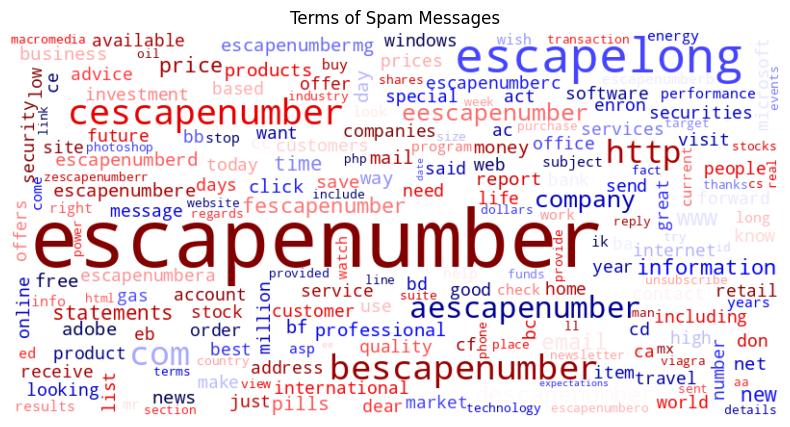

In [ ]:
# Separate spam messages
spam = df[df['label'].str.strip().str.lower() == 'spam']

# Tokenize and count terms
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(spam['text'])
term_freq = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

# Create a DataFrame with term frequencies
freq_df = pd.DataFrame({'Term': terms, 'Frequency': term_freq})
freq_df = freq_df.sort_values(by='Frequency', ascending=False)

# Convert to dictionary for word cloud
data = dict(zip(freq_df['Term'], freq_df['Frequency']))

# Generate word cloud
spam_wordcloud = WordCloud(background_color='white',
                          colormap='seismic',
                          width=800,
                          height=400,
                          max_words=200).generate_from_frequencies(data)

# Plot word cloud
plt.figure(figsize=(10, 5))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Terms of Spam Messages')
plt.show()


In [ ]:
dataset_info = {
    "Number of Rows": len(df),
    "Number of Columns": df.shape[1],
    "Missing Values": df.isnull().sum(),
    "Spam Distribution": df['label'].value_counts(normalize=True) * 100
}

dataset_info

{'Number of Rows': 118632,
 'Number of Columns': 3,
 'Missing Values': label     0
 text      0
 length    0
 dtype: int64,
 'Spam Distribution': label
 Ham     52.538944
 Spam    47.461056
 Name: proportion, dtype: float64}

In [ ]:
df.describe(include='all')

,label,text,length
count,118632,118632,1.186320e+05
unique,2,118631,NaN
top,Ham,hi,NaN
freq,62328,2,NaN
mean,NaN,NaN,1.850208e+03
std,NaN,NaN,3.380749e+04
min,NaN,NaN,1.000000e+00
25%,NaN,NaN,3.600000e+02
50%,NaN,NaN,7.970000e+02
75%,NaN,NaN,1.807000e+03


In [ ]:
df.groupby("label").describe()

length                                                        \
         count         mean           std  min    25%    50%     75%   
label                                                                  
Ham    62328.0  2240.355554  46579.729509  1.0  417.0  948.0  1970.0   
Spam   56304.0  1418.318592   2456.661199  1.0  306.0  669.0  1571.0   

                   
              max  
label              
Ham    11510306.0  
Spam     144087.0

In [ ]:
df.label.value_counts()

,count
label,
Ham,62328
Spam,56304


In [ ]:
# Ensure all text data is string and handle missing values
df['text'] = df['text'].astype(str).fillna('')

# Define clean_text function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces and strip leading/trailing spaces
    return text

# Apply the cleaning function to the dataset
df['clean_text'] = df['text'].apply(clean_text)

# Check the cleaned text
print(df[['text', 'clean_text']].head())


                                                text  \
0  viiiiiiagraaaa\nonly for the ones that want to...   
1  got ice thought look az original message ice o...   
2  yo ur wom an ne eds an escapenumber in ch ma n...   
3  start increasing your odds of success & live s...   
4  author jra date escapenumber escapenumber esca...   

                                          clean_text  
0  viiiiiiagraaaa only for the ones that want to ...  
1  got ice thought look az original message ice o...  
2  yo ur wom an ne eds an escapenumber in ch ma n...  
3  start increasing your odds of success live sex...  
4  author jra date escapenumber escapenumber esca...  


In [ ]:
# Preprocessing
texts = df['clean_text'].values
labels = df['label'].values

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

#### Data Processing using Sequence Based Method

In [ ]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(texts, labels_encoded, test_size=0.2, random_state=42)

# Tokenization and Padding
max_words = 5000
max_len = 150

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

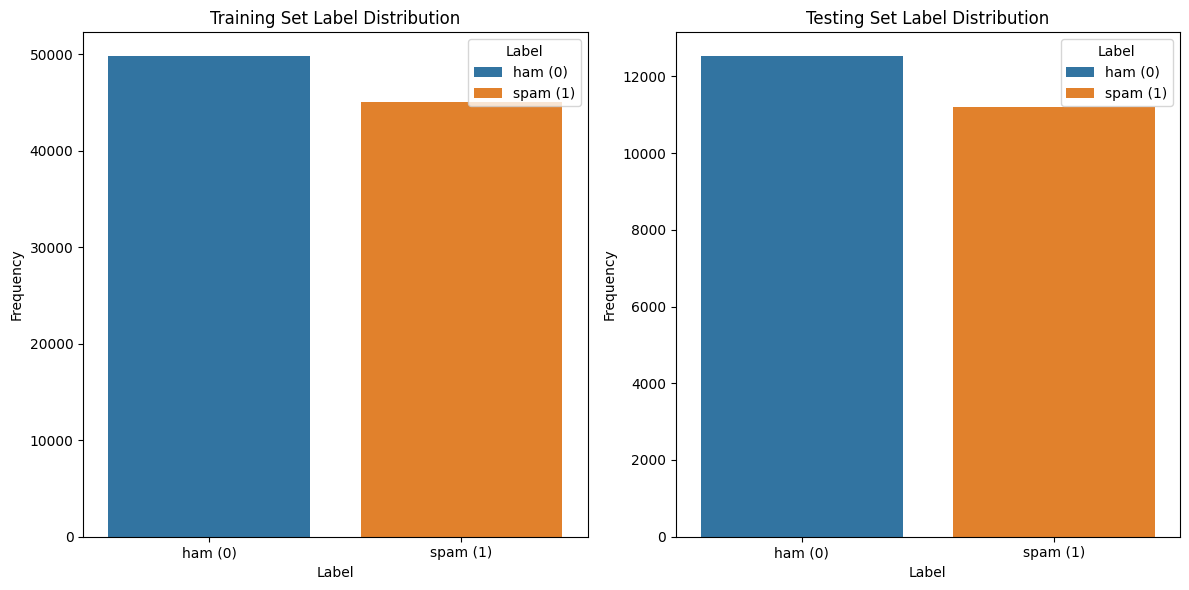

In [ ]:
# Create a DataFrame for easy plotting
data = pd.DataFrame({
    'Set': ['Training'] * len(y_train) + ['Testing'] * len(y_test),
    'Label': list(y_train) + list(y_test)
})
# Define colors
color_map = {0: '#1f77b4', 1: '#ff7f0e'}  # Map colors to label
# Plot histograms
plt.figure(figsize=(12, 6))

# Training Set Histogram
plt.subplot(1, 2, 1)
sns.countplot(x='Label', data=data[data['Set'] == 'Training'], hue='Label', palette=color_map)
plt.title('Training Set Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['ham (0)', 'spam (1)'])
plt.legend(title='Label', labels=['ham (0)', 'spam (1)'], loc='upper right')

# Testing Set Histogram
plt.subplot(1, 2, 2)
sns.countplot(x='Label', data=data[data['Set'] == 'Testing'], hue='Label', palette=color_map)
plt.title('Testing Set Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['ham (0)', 'spam (1)'])
plt.legend(title='Label', labels=['ham (0)', 'spam (1)'], loc='upper right')

plt.tight_layout()
plt.show()


#### Advance Individual Model

##### CNN Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 5000, 128)           │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 4996, 64)            │          41,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1249, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1249, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 79936)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │         799,370 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,480,405 (5.65 MB)

 Trainable params: 1,480,405 (5.65 MB)

 Non-trainable params: 0 (0.00 B)

None


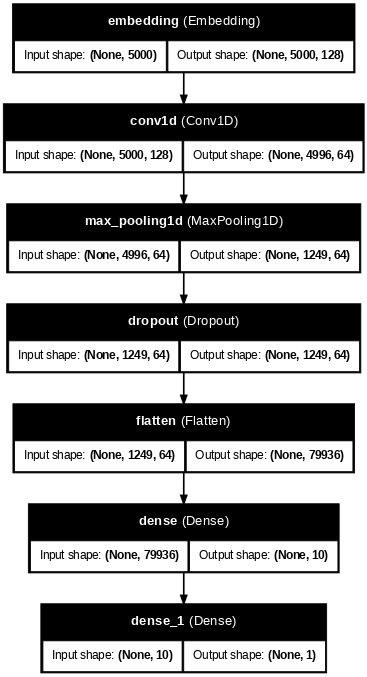

In [ ]:

# Parameters for the model
max_words = 5000  # Adjust this based on your vocabulary size

# Define the CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128))  # Removed input_length
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the CNN model instance
model_cnn = create_cnn_model()

# Build the model by specifying the input shape
model_cnn.build(input_shape=(None, max_words))

# Print the model summary
print(model_cnn.summary())

# Show the model architecture with a smaller size
tf.keras.utils.plot_model(
    model_cnn,
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


##### RNN Model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 5000, 128)           │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 674,197 (2.57 MB)

 Trainable params: 674,197 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

None


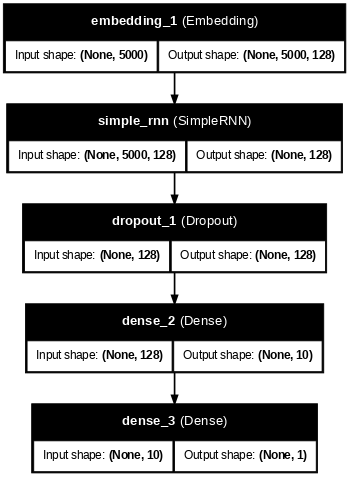

In [ ]:

# Parameters for the model
max_words = 5000  # Adjust this based on your vocabulary size

# Define the RNN model
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128))  # Removed input_length
    model.add(SimpleRNN(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the RNN model instance
model_rnn = create_rnn_model()

# Build the model by specifying the input shape
model_rnn.build(input_shape=(None, max_words))

# Print the model summary
print(model_rnn.summary())

# Show the model architecture with a smaller size
tf.keras.utils.plot_model(
    model_rnn,          # Corrected variable name
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


##### LSTM Model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 5000, 128)           │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 772,885 (2.95 MB)

 Trainable params: 772,885 (2.95 MB)

 Non-trainable params: 0 (0.00 B)

None


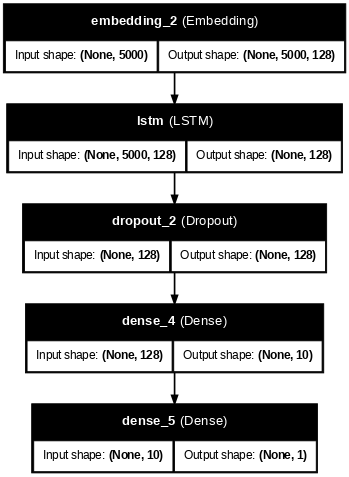

In [ ]:


# Parameters for the model
max_words = 5000  # Adjust this based on your vocabulary size

# Define the LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=max_words, output_dim=128))  # Removed input_length
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the LSTM model instance
model_lstm = create_lstm_model()

# Build the model by specifying the input shape
model_lstm.build(input_shape=(None, max_words))

# Print the model summary
print(model_lstm.summary())

# Show the model architecture with a smaller size
tf.keras.utils.plot_model(
    model_lstm,
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


##### Evaluation of Individual Model

In [ ]:

# Define class labels
class_labels = ['ham', 'spam']

# Train and Evaluate Models with Detailed Metrics
def train_and_evaluate_model(model, model_name, X_train, y_train, X_test, y_test, epochs=50):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_split=0.2,
        verbose=2,
        callbacks=[early_stopping]
    )
    end_time = time.time()

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    response_time = end_time - start_time

    print(f"\nModel: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Response Time: {response_time:.4f} seconds")

    # Generate classification report
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {model_name}:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return history, accuracy, precision, recall, f1, response_time


Epoch 1/50
2373/2373 - 136s - 58ms/step - accuracy: 0.9452 - loss: 0.1384 - val_accuracy: 0.9692 - val_loss: 0.0861
Epoch 2/50
2373/2373 - 122s - 51ms/step - accuracy: 0.9759 - loss: 0.0676 - val_accuracy: 0.9723 - val_loss: 0.0788
Epoch 3/50
2373/2373 - 144s - 61ms/step - accuracy: 0.9842 - loss: 0.0464 - val_accuracy: 0.9708 - val_loss: 0.0928
Epoch 4/50
2373/2373 - 137s - 58ms/step - accuracy: 0.9884 - loss: 0.0338 - val_accuracy: 0.9726 - val_loss: 0.0970
Epoch 5/50
2373/2373 - 142s - 60ms/step - accuracy: 0.9905 - loss: 0.0279 - val_accuracy: 0.9726 - val_loss: 0.1092
Epoch 6/50
2373/2373 - 150s - 63ms/step - accuracy: 0.9923 - loss: 0.0232 - val_accuracy: 0.9732 - val_loss: 0.1150
Epoch 7/50
2373/2373 - 133s - 56ms/step - accuracy: 0.9930 - loss: 0.0211 - val_accuracy: 0.9736 - val_loss: 0.1231
742/742 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step

Model: CNN Model
Accuracy: 0.9717
Precision: 0.9653
Recall: 0.9751
F1 Score: 0.9702
Response Time: 965.3993 seconds

Classification Report for C

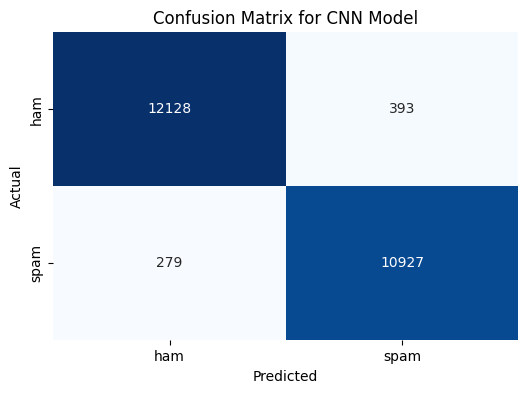

Epoch 1/50
2373/2373 - 185s - 78ms/step - accuracy: 0.8393 - loss: 0.3647 - val_accuracy: 0.9236 - val_loss: 0.2152
Epoch 2/50
2373/2373 - 181s - 76ms/step - accuracy: 0.9199 - loss: 0.2307 - val_accuracy: 0.9388 - val_loss: 0.1807
Epoch 3/50
2373/2373 - 179s - 76ms/step - accuracy: 0.9270 - loss: 0.2108 - val_accuracy: 0.8977 - val_loss: 0.2713
Epoch 4/50
2373/2373 - 203s - 86ms/step - accuracy: 0.9272 - loss: 0.2027 - val_accuracy: 0.9329 - val_loss: 0.1907
Epoch 5/50
2373/2373 - 200s - 84ms/step - accuracy: 0.9385 - loss: 0.1839 - val_accuracy: 0.7554 - val_loss: 0.4909
Epoch 6/50
2373/2373 - 203s - 86ms/step - accuracy: 0.9201 - loss: 0.2103 - val_accuracy: 0.9516 - val_loss: 0.1473
Epoch 7/50
2373/2373 - 209s - 88ms/step - accuracy: 0.9478 - loss: 0.1474 - val_accuracy: 0.9417 - val_loss: 0.1528
Epoch 8/50
2373/2373 - 196s - 83ms/step - accuracy: 0.9330 - loss: 0.1843 - val_accuracy: 0.9247 - val_loss: 0.2079
Epoch 9/50
2373/2373 - 203s - 85ms/step - accuracy: 0.9487 - loss: 0.158

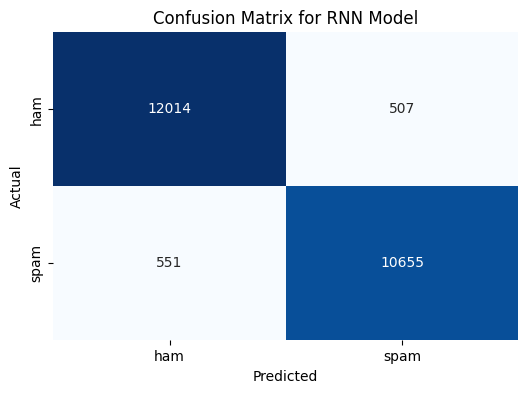

Epoch 1/50
2373/2373 - 767s - 323ms/step - accuracy: 0.9402 - loss: 0.1647 - val_accuracy: 0.9661 - val_loss: 0.1078
Epoch 2/50
2373/2373 - 788s - 332ms/step - accuracy: 0.9723 - loss: 0.0846 - val_accuracy: 0.9455 - val_loss: 0.1526
Epoch 3/50


KeyboardInterrupt: 

In [ ]:

# Create and evaluate CNN model
cnn_model = create_cnn_model()
cnn_history, cnn_accuracy, cnn_precision, cnn_recall, cnn_f1, cnn_response_time = train_and_evaluate_model(
    cnn_model, "CNN Model", X_train_pad, y_train, X_test_pad, y_test)

# Create and evaluate RNN model
rnn_model = create_rnn_model()
rnn_history, rnn_accuracy, rnn_precision, rnn_recall, rnn_f1, rnn_response_time = train_and_evaluate_model(
    rnn_model, "RNN Model", X_train_pad, y_train, X_test_pad, y_test)

# Create and evaluate LSTM model
lstm_model = create_lstm_model()
lstm_history, lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_response_time = train_and_evaluate_model(
    lstm_model, "LSTM Model", X_train_pad, y_train, X_test_pad, y_test)


In [ ]:

# Plotting training and validation history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(cnn_history, 'CNN')
plot_history(rnn_history, 'RNN')
plot_history(lstm_history, 'LSTM')


##### Comparing the Individual Models

In [ ]:

# Define metrics dictionary
metrics = {
    'CNN': [cnn_accuracy, cnn_precision, cnn_recall, cnn_f1, cnn_response_time],
    'RNN': [rnn_accuracy, rnn_precision, rnn_recall, rnn_f1, rnn_response_time],
    'LSTM': [lstm_accuracy, lstm_precision, lstm_recall, lstm_f1, lstm_response_time]
}

# Define metric names
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Create DataFrame for metrics
metrics_df = pd.DataFrame({
    model: [value * 100 for value in values[:-1]]  # Exclude the response time and multiply by 100
    for model, values in metrics.items()
}, index=metric_names).T

# Plot the metrics
plt.figure(figsize=(12, 8))
ax = metrics_df.plot(kind='bar', figsize=(10, 6))

plt.ylim(0, 110)  # Adjust y-axis limits to accommodate percentages

# Add bar labels with diagonal percentage formatting
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=10, rotation=45, label_type='edge')  # Rotate labels

plt.title("Evaluation Metrics for Individual Models")
plt.xlabel("Model")
plt.ylabel("Score (%)")
plt.xticks(rotation=45)
plt.legend(title='Metrics', loc='lower right')
plt.show()


##### ROC curve of the models

In [ ]:

# Function to plot ROC Curves for multiple models
def plot_roc_curves(model_names, y_test, y_pred_probs):
    plt.figure(figsize=(10, 8))

    for model_name, y_pred_prob in zip(model_names, y_pred_probs):
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve with AUC value formatted to four decimal places
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

    # Plot settings
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(False)
    plt.show()

# Example usage
model_names = ['CNN', 'RNN', 'LSTM']
y_pred_probs = [
    cnn_model.predict(X_test_pad).ravel(),
    rnn_model.predict(X_test_pad).ravel(),
    lstm_model.predict(X_test_pad).ravel()
]

plot_roc_curves(model_names, y_test, y_pred_probs)


#### Hybrid Models Considered

##### CNN-RNN Model

In [ ]:
# Import necessary libraries
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, SimpleRNN, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# Parameters for the model
max_words = 5000  # The size of the vocabulary (number of unique words to consider)
max_len = 150     # The maximum length of input sequences (padded/truncated)

# Define the CNN-RNN model
def create_cnn_rnn_model():
    input_layer = Input(shape=(max_len,))
    x = Embedding(input_dim=max_words, output_dim=128)(input_layer)
    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
    x = MaxPooling1D(pool_size=4)(x)
    x = SimpleRNN(128, return_sequences=False)(x)
    x = Dropout(0.5)(x)
    x = Dense(10, activation='relu')(x)  # Consider adjusting the number of units here based on your problem
    output_layer = Dense(1, activation='sigmoid')(x)  # For binary classification
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the CNN-RNN model instance
model_cnn_rnn = create_cnn_rnn_model()

# Print the model summary
model_cnn_rnn.summary()

# Show the model architecture
tf.keras.utils.plot_model(
    model_cnn_rnn,
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


##### CNN-LSTM model

In [ ]:

# Parameters for the model
max_words = 5000  # The size of the vocabulary (number of unique words to consider)
max_len = 150     # The maximum length of input sequences (padded/truncated)

# Define the CNN-LSTM model
def create_cnn_lstm_model():
    input_layer = Input(shape=(max_len,))
    x = Embedding(input_dim=max_words, output_dim=128)(input_layer)  # Embedding layer for word vectors
    x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)      # Convolutional layer for feature extraction
    x = MaxPooling1D(pool_size=4)(x)                                 # Max pooling layer to downsample the input
    x = LSTM(128, return_sequences=False)(x)                         # LSTM layer for sequential data processing
    x = Dropout(0.5)(x)                                              # Dropout layer for regularization
    x = Dense(10, activation='relu')(x)                              # Dense layer for further processing
    output_layer = Dense(1, activation='sigmoid')(x)                 # Output layer for binary classification
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the CNN-LSTM model instance
model_cnn_lstm = create_cnn_lstm_model()

# Print the model summary
model_cnn_lstm.summary()

# Show the model architecture
tf.keras.utils.plot_model(
    model_cnn_lstm,
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


##### RNN-LSTM Model

In [ ]:

# Parameters for the model
max_words = 5000  # The size of the vocabulary (number of unique words to consider)
max_len = 150     # The maximum length of input sequences (padded/truncated)

# Define the RNN-LSTM model
def create_rnn_lstm_model():
    input_layer = Input(shape=(max_len,))
    x = Embedding(input_dim=max_words, output_dim=128)(input_layer)  # Embedding layer for word vectors
    x = SimpleRNN(128, return_sequences=True)(x)                     # SimpleRNN layer for short-term dependencies
    x = LSTM(128, return_sequences=False)(x)                         # LSTM layer for long-term dependencies
    x = Dropout(0.5)(x)                                              # Dropout layer for regularization
    x = Dense(10, activation='relu')(x)                              # Dense layer for further processing
    output_layer = Dense(1, activation='sigmoid')(x)                 # Output layer for binary classification
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create the RNN-LSTM model instance
model_rnn_lstm = create_rnn_lstm_model()

# Print the model summary
model_rnn_lstm.summary()

# Show the model architecture
tf.keras.utils.plot_model(
    model_rnn_lstm,
    show_shapes=True,
    show_layer_names=True,
    dpi=60  # Adjust DPI for smaller image size
)


##### Evaluation of Each Combination

In [ ]:
# Import the necessary modules
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# CNN-RNN Model Training and Evaluation

print("Training CNN-RNN model...")

# Create the CNN-RNN model
model_cnn_rnn = create_cnn_rnn_model()

# Define EarlyStopping callback
early_stopping_cnn_rnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN-RNN model
history_cnn_rnn = model_cnn_rnn.fit(
    X_train_pad,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stopping_cnn_rnn]
)

# Create a dictionary to store the training history
history_combine = {}

# Save training history
history_combine['CNN-RNN'] = history_cnn_rnn.history

# Evaluate the CNN-RNN model on test data
y_pred_cnn_rnn = (model_cnn_rnn.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Calculate metrics
accuracy_cnn_rnn = accuracy_score(y_test, y_pred_cnn_rnn)
precision_cnn_rnn = precision_score(y_test, y_pred_cnn_rnn)
recall_cnn_rnn = recall_score(y_test, y_pred_cnn_rnn)
f1_cnn_rnn = f1_score(y_test, y_pred_cnn_rnn)

# Create a dictionary to store metrics
metric_combine = {}

metric_combine['CNN-RNN'] = {
    'Accuracy': accuracy_cnn_rnn,
    'Precision': precision_cnn_rnn,
    'Recall': recall_cnn_rnn,
    'F1 Score': f1_cnn_rnn
}

# Generate and plot the confusion matrix
cm_cnn_rnn = confusion_matrix(y_test, y_pred_cnn_rnn)
plt.figure(figsize=(6, 4))
disp_cnn_rnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_rnn, display_labels=class_labels)
disp_cnn_rnn.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN-RNN')
plt.show()

# Generate and print the classification report
# Create the reports dictionary
reports = {}
report_cnn_rnn = classification_report(y_test, y_pred_cnn_rnn, target_names=class_labels)
reports['CNN-RNN'] = report_cnn_rnn
print(f"CNN-RNN model metrics:\nAccuracy: {accuracy_cnn_rnn:.4f}\nPrecision: {precision_cnn_rnn:.4f}\nRecall: {recall_cnn_rnn:.4f}\nF1 Score: {f1_cnn_rnn:.4f}\n")
print(f"Classification Report for CNN-RNN:\n", report_cnn_rnn)


In [ ]:
# CNN-LSTM Model Training and Evaluation

print("Training CNN-LSTM model...")

# Create the CNN-LSTM model
model_cnn_lstm = create_cnn_lstm_model()

# Define EarlyStopping callback
early_stopping_cnn_lstm = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the CNN-LSTM model
history_cnn_lstm = model_cnn_lstm.fit(
    X_train_pad,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stopping_cnn_lstm]
)

# Save training history
history_combine['CNN-LSTM'] = history_cnn_lstm.history

# Evaluate the CNN-LSTM model on test data
y_pred_cnn_lstm = (model_cnn_lstm.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Calculate metrics
accuracy_cnn_lstm = accuracy_score(y_test, y_pred_cnn_lstm)
precision_cnn_lstm = precision_score(y_test, y_pred_cnn_lstm)
recall_cnn_lstm = recall_score(y_test, y_pred_cnn_lstm)
f1_cnn_lstm = f1_score(y_test, y_pred_cnn_lstm)

metric_combine['CNN-LSTM'] = {
    'Accuracy': accuracy_cnn_lstm,
    'Precision': precision_cnn_lstm,
    'Recall': recall_cnn_lstm,
    'F1 Score': f1_cnn_lstm
}

# Generate and plot the confusion matrix
cm_cnn_lstm = confusion_matrix(y_test, y_pred_cnn_lstm)
plt.figure(figsize=(6, 4))
disp_cnn_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_lstm, display_labels=class_labels)
disp_cnn_lstm.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN-LSTM')
plt.show()

# Generate and print the classification report
report_cnn_lstm = classification_report(y_test, y_pred_cnn_lstm, target_names=class_labels)
reports['CNN-LSTM'] = report_cnn_lstm
print(f"CNN-LSTM model metrics:\nAccuracy: {accuracy_cnn_lstm:.4f}\nPrecision: {precision_cnn_lstm:.4f}\nRecall: {recall_cnn_lstm:.4f}\nF1 Score: {f1_cnn_lstm:.4f}\n")
print(f"Classification Report for CNN-LSTM:\n", report_cnn_lstm)


In [ ]:
# RNN-LSTM Model Training and Evaluation

print("Training RNN-LSTM model...")

# Create the RNN-LSTM model
model_rnn_lstm = create_rnn_lstm_model()

# Define EarlyStopping callback
early_stopping_rnn_lstm = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the RNN-LSTM model
history_rnn_lstm = model_rnn_lstm.fit(
    X_train_pad,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stopping_rnn_lstm]
)

# Save training history
history_combine['RNN-LSTM'] = history_rnn_lstm.history

# Evaluate the RNN-LSTM model on test data
y_pred_rnn_lstm = (model_rnn_lstm.predict(X_test_pad) > 0.5).astype("int32").flatten()

# Calculate metrics
accuracy_rnn_lstm = accuracy_score(y_test, y_pred_rnn_lstm)
precision_rnn_lstm = precision_score(y_test, y_pred_rnn_lstm)
recall_rnn_lstm = recall_score(y_test, y_pred_rnn_lstm)
f1_rnn_lstm = f1_score(y_test, y_pred_rnn_lstm)

metric_combine['RNN-LSTM'] = {
    'Accuracy': accuracy_rnn_lstm,
    'Precision': precision_rnn_lstm,
    'Recall': recall_rnn_lstm,
    'F1 Score': f1_rnn_lstm
}

# Generate and plot the confusion matrix
cm_rnn_lstm = confusion_matrix(y_test, y_pred_rnn_lstm)
plt.figure(figsize=(6, 4))
disp_rnn_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_rnn_lstm, display_labels=class_labels)
disp_rnn_lstm.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for RNN-LSTM')
plt.show()

# Generate and print the classification report
report_rnn_lstm = classification_report(y_test, y_pred_rnn_lstm, target_names=class_labels)
reports['RNN-LSTM'] = report_rnn_lstm
print(f"RNN-LSTM model metrics:\nAccuracy: {accuracy_rnn_lstm:.4f}\nPrecision: {precision_rnn_lstm:.4f}\nRecall: {recall_rnn_lstm:.4f}\nF1 Score: {f1_rnn_lstm:.4f}\n")
print(f"Classification Report for RNN-LSTM:\n", report_rnn_lstm)


##### Training History for the Hybrid Models

In [ ]:

# Plot training history for each model
for name, history in history_combine.items():
    plt.figure(figsize=(12, 6))

    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f'Training History for {name}')
    plt.show()

In [ ]:
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'{name} - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [ ]:
# Convert metrics dictionary to a DataFrame for easier plotting
metrics_df = pd.DataFrame(metric_combine).T

# Define plot size
plt.figure(figsize=(8, 8))

# Define bar width and positions
bar_width = 0.1
index = np.arange(len(metrics_df))

# Plot each metric
for i, metric in enumerate(metrics_df.columns):
    bars = plt.bar(index + i * bar_width, metrics_df[metric] * 100, bar_width,
                   label=metric, color=['blue', 'green', 'red', 'orange'][i])

    # Annotate bars with the exact percentage value
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}%',
                 ha='center', va='bottom', fontsize=9, rotation=45, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Percentage (%)')
plt.title('Comparison of Evaluation Metrics for Combined Models')

# Adjust x-axis labels to avoid overlap
plt.xticks(index + bar_width * (len(metrics_df.columns) / 2) - bar_width / 2, metrics_df.index, rotation=45)

# Adjust plot margins to ensure everything fits
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the margins

plt.legend(loc='best')
plt.show()

##### Roc of Best Hybrid

In [ ]:
metric_combine

In [ ]:
history_combine

In [ ]:
combined_models = {model_cnn_rnn, model_cnn_lstm, model_rnn_lstm}

In [ ]:

# Prepare the figure
plt.figure(figsize=(10, 8))

# combined_models was defined as a set but you probably meant to
# define it as a dictionary so you can iterate through key-value pairs.
combined_models = {'model_cnn_rnn': model_cnn_rnn,
                   'model_cnn_lstm': model_cnn_lstm,
                   'model_rnn_lstm': model_rnn_lstm}


# Iterate over each model to compute and plot ROC curve
for model_name, model in combined_models.items():
    # Predict probabilities
    y_proba = model.predict(X_test_pad).flatten()

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

# Plot the diagonal line (no redundant arguments)
plt.plot([0, 1], [0, 1], 'r--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()


#### Comparison of All Models

In [ ]:

# Metrics for CNN, RNN, LSTM
cnn_metrics = metric_combine.get('CNN Model', {})
rnn_metrics = metric_combine.get('RNN Model', {})
lstm_metrics = metric_combine.get('LSTM Model', {})

# Combine metrics with combined models
combined_cnn_rnn_metrics = metric_combine.get('CNN-RNN', {})
combined_cnn_lstm_metrics = metric_combine.get('CNN-LSTM', {})
combined_rnn_lstm_metrics = metric_combine.get('RNN-LSTM', {})

# All metrics to compare
models = ['CNN', 'RNN', 'LSTM', 'CNN-RNN', 'CNN-LSTM', 'RNN-LSTM']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Create lists for metric values
metric_values = {metric: [] for metric in metrics}

# Populate metric values for each model
for model in models:
    if model == 'CNN':
        metrics_data = cnn_metrics
    elif model == 'RNN':
        metrics_data = rnn_metrics
    elif model == 'LSTM':
        metrics_data = lstm_metrics
    elif model == 'CNN-RNN':
        metrics_data = combined_cnn_rnn_metrics
    elif model == 'CNN-LSTM':
        metrics_data = combined_cnn_lstm_metrics
    elif model == 'RNN-LSTM':
        metrics_data = combined_rnn_lstm_metrics

    for metric in metrics:
        metric_values[metric].append(metrics_data.get(metric, 0))

# Set up bar width and positions
bar_width = 0.15
bar_positions = np.arange(len(models))

# Plot bars for each metric
plt.figure(figsize=(16, 8))
for i, metric in enumerate(metrics):
    plt.bar(
        bar_positions + i * bar_width,
        metric_values[metric],
        bar_width,
        label=metric
    )

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Different Models Across Metrics')
plt.xticks(bar_positions + bar_width * (len(metrics) / 2 - 0.5), models)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()


#### Patterns of Misclassified Emails

## **model_cnn_rnn misclassified**

In [ ]:
# Assuming 'model_rnn_lstm' is your trained RNN-LSTM model object
y_pred = model_cnn_rnn.predict(X_test_pad)

# Compare y_test with the first column of y_pred since it is a 2D array
misclassified_indices = y_test != y_pred[:,0]
misclassified_emails = X_test_pad[misclassified_indices]
misclassified_labels = y_test[misclassified_indices]
misclassified_predictions = y_pred[misclassified_indices]

In [ ]:
for email, true_label, predicted_label in zip(misclassified_emails, misclassified_labels, misclassified_predictions):
    print(f"Email: {email}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    print("\n")

In [ ]:
def display_misclassified_emails(misclassified_indices, X_test_pad, y_test, y_pred):
    for idx in misclassified_indices[:10]:  # Adjust the slice to control how many emails you want to display
        email_content = X_test_pad[idx][:50]  # Display the first 50 tokens
        true_label = y_test[idx]
        predicted_label = y_pred[idx]

        print(f"Email (first 50 tokens): {email_content}")
        print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
        print("\n---\n")

# Get indices of misclassified emails
misclassified_indices = np.where(y_test != y_pred)[0]

# Display a sample of misclassified emails
display_misclassified_emails(misclassified_indices, X_test_pad, y_test, y_pred)

# **model_cnn_lstm misclassified**

In [ ]:
# Assuming 'model_rnn_lstm' is your trained RNN-LSTM model object
y_pred = model_cnn_lstm.predict(X_test_pad)

# Compare y_test with the first column of y_pred since it is a 2D array
misclassified_indices = y_test != y_pred[:,0]
misclassified_emails = X_test_pad[misclassified_indices]
misclassified_labels = y_test[misclassified_indices]
misclassified_predictions = y_pred[misclassified_indices]


In [ ]:
for email, true_label, predicted_label in zip(misclassified_emails, misclassified_labels, misclassified_predictions):
    print(f"Email: {email}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    print("\n")


In [ ]:
def display_misclassified_emails(misclassified_indices, X_test_pad, y_test, y_pred):
    for idx in misclassified_indices[:10]:  # Adjust the slice to control how many emails you want to display
        email_content = X_test_pad[idx][:50]  # Display the first 50 tokens
        true_label = y_test[idx]
        predicted_label = y_pred[idx]

        print(f"Email (first 50 tokens): {email_content}")
        print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
        print("\n---\n")

# Get indices of misclassified emails
misclassified_indices = np.where(y_test != y_pred)[0]

# Display a sample of misclassified emails
display_misclassified_emails(misclassified_indices, X_test_pad, y_test, y_pred)

# **model_rnn_lstm misclassified**

In [ ]:
# Assuming 'model_rnn_lstm' is your trained RNN-LSTM model object
y_pred = model_rnn_lstm.predict(X_test_pad)

# Compare y_test with the first column of y_pred since it is a 2D array
misclassified_indices = y_test != y_pred[:,0]
misclassified_emails = X_test_pad[misclassified_indices]
misclassified_labels = y_test[misclassified_indices]
misclassified_predictions = y_pred[misclassified_indices]


In [ ]:
for email, true_label, predicted_label in zip(misclassified_emails, misclassified_labels, misclassified_predictions):
    print(f"Email: {email}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    print("\n")


In [ ]:
def display_misclassified_emails(misclassified_indices, X_test_pad, y_test, y_pred):
    for idx in misclassified_indices[:10]:  # Adjust the slice to control how many emails you want to display
        email_content = X_test_pad[idx][:50]  # Display the first 50 tokens
        true_label = y_test[idx]
        predicted_label = y_pred[idx]

        print(f"Email (first 50 tokens): {email_content}")
        print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
        print("\n---\n")

# Get indices of misclassified emails
misclassified_indices = np.where(y_test != y_pred)[0]


prediction

In [ ]:
# Assuming 'model_cnn' is your trained model
model_cnn_lstm.save('cnn_lstm.h5')  # Save model to HDF5 format


In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Load the model
loaded_model = load_model('cnn_lstm.h5')

# Load or define the tokenizer
# Ensure you have the same tokenizer used for training
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(training_texts)  # or load from a saved tokenizer if you saved it

# Prepare input text
texts_to_predict = ["informatics & engineering department"]
texts_seq = tokenizer.texts_to_sequences(texts_to_predict)
texts_pad = pad_sequences(texts_seq, maxlen=max_len)

# Make predictions
predictions = loaded_model.predict(texts_pad)
predicted_classes = (predictions > 0.5).astype("int32")


print(predicted_classes)
